# <center>**Milestone 2**<center>

## **Import**

In [332]:
import os
import json
import gc
import pickle
import sys
import random
import glob
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from __future__ import annotations
from collections import defaultdict

from my_scanner import *
from my_parser import *
from my_matcher import *
from my_featureEngineering import *
from my_modeling import *
from my_evaluation import *

## **Configuration**


In [333]:
RAW_ROOT = "../30-paper"
USING_SHA256_HASH = False

# 1. Output directory
OUTPUT_DIR = "23127453"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configuration for caching
CACHE_DIR = ".cache"
os.makedirs(CACHE_DIR, exist_ok=True)
sys.setrecursionlimit(20000)

MANUAL_DIR = "manual_labeling"
os.makedirs(MANUAL_DIR, exist_ok=True)

random.seed(42)

## **Dataset rescan**


In [334]:
scan_result = scan_dataset(RAW_ROOT)

for k, v in scan_result.items():
    print(k, v["status"], v["versions"])

2211-13747 NO_TEX []
2211-13748 READY ['2211-13748v1']
2211-13749 READY ['2211-13749v1']
2211-13750 READY ['2211-13750v1', '2211-13750v2']
2211-13751 READY ['2211-13751v1']
2211-13752 READY ['2211-13752v1']
2211-13753 READY ['2211-13753v1']
2211-13754 READY ['2211-13754v1']
2211-13755 READY ['2211-13755v1', '2211-13755v2']
2211-13756 READY ['2211-13756v1', '2211-13756v2']
2211-13757 READY ['2211-13757v1', '2211-13757v2']
2211-13758 READY ['2211-13758v1']
2211-13759 READY ['2211-13759v1', '2211-13759v2']
2211-13760 READY ['2211-13760v1', '2211-13760v2']
2211-13761 READY ['2211-13761v1']
2211-13762 READY ['2211-13762v1', '2211-13762v2']
2211-13763 READY ['2211-13763v1']
2211-13764 READY ['2211-13764v1']
2211-13765 READY ['2211-13765v1']
2211-13766 READY ['2211-13766v1', '2211-13766v2', '2211-13766v3']
2211-13767 READY ['2211-13767v1']
2211-13768 READY ['2211-13768v1', '2211-13768v2']
2211-13769 READY ['2211-13769v1', '2211-13769v2']
2211-13770 READY ['2211-13770v1']
2211-13771 READY ['22

## **Version-level Multi-file Resolver**


In [335]:
pub_results = []

ready_items = [
    (pub_id, info)
    for pub_id, info in scan_result.items()
    if info["status"] == "READY"
]

for pub_id, info in tqdm(ready_items, desc="Publications"):
    for version in info["versions"]:
        version_path = f"{RAW_ROOT}/{pub_id}/tex/{version}"

        result = resolve_version(
            publication_id=pub_id,
            version_name=version,
            version_path=version_path
        )

        pub_results.append(result)

# Xem kết quả
for r in pub_results:
    print(r["publication_id"], r["version"], r["used_tex_files"])


Publications: 100%|██████████| 29/29 [00:00<00:00, 451.19it/s]

2211-13748 2211-13748v1 ['weibo.tex']
2211-13749 2211-13749v1 ['On_projections_of_tailsvA.tex']
2211-13750 2211-13750v1 ['comparingsinglettestingschemes.tex']
2211-13750 2211-13750v2 ['comparingsinglettestingschemes4.tex']
2211-13751 2211-13751v1 ['Kane_et_al_JFM_v1.tex']
2211-13752 2211-13752v1 ['main.tex', 'macros.tex', '00_abstract.tex', '01_intro.tex', '02_related.tex', '03_method.tex', '04_results.tex', '05_conclusion.tex', '07_acc.tex', '06_appendix.tex']
2211-13753 2211-13753v1 ['0-title.tex']
2211-13754 2211-13754v1 ['main.tex']
2211-13755 2211-13755v1 ['main.tex']
2211-13755 2211-13755v2 ['main.tex']
2211-13756 2211-13756v1 ['main.tex']
2211-13756 2211-13756v2 ['main.tex']
2211-13757 2211-13757v1 ['main.tex']
2211-13757 2211-13757v2 ['main.tex']
2211-13758 2211-13758v1 ['main.tex']
2211-13759 2211-13759v1 ['main.tex']
2211-13759 2211-13759v2 ['main.tex']
2211-13760 2211-13760v1 ['main.tex']
2211-13760 2211-13760v2 ['main.tex']
2211-13761 2211-13761v1 ['main.tex']
2211-13762 22

## **LaTeX Hierarchy Parser**

We parsed each LaTeX version into a hierarchical tree structure. Sectioning commands were treated as internal nodes, while only sentences, tables, and figures were considered leaf nodes, strictly following the seminar constraints. No deduplication or identifier assignment was performed at this stage.


In [336]:
def save_tree_to_cache(pub_id: str, version: str, root: FileNode) -> str:
    """
    Serialize tree to disk and return cache path.
    Returns the cache file path for later retrieval.
    """
    cache_path = os.path.join(CACHE_DIR, f"{pub_id}_{version}.pkl")
    with open(cache_path, "wb") as f:
        pickle.dump(root, f, protocol=4)
    return cache_path

def load_tree_from_cache(cache_path: str) -> FileNode:
    """Load tree from cache file."""
    with open(cache_path, "rb") as f:
        return pickle.load(f)

In [337]:
parsed_versions = []


for version_info in tqdm(
    pub_results,
    desc="Parsing LaTeX versions",
    unit="version(s)"
):
    if version_info["status"] != "RESOLVED":
        continue

    version_path = (
        f"{RAW_ROOT}/"
        f"{version_info['publication_id']}/tex/"
        f"{version_info['version']}"
    )

    try:
        root_node = parse_tex_files(
            version_path=version_path,
            tex_files=version_info["used_tex_files"]
        )

        # Save to disk instead of keeping in memory
        cache_path = save_tree_to_cache(
            pub_id=version_info["publication_id"],
            version=version_info["version"],
            root=root_node
        )

        parsed_versions.append({
            "publication_id": version_info["publication_id"],
            "version": version_info["version"],
            "cache_path": cache_path,  # Store path, not tree
            "root": None  # Placeholder
        })

        # Explicitly free memory
        del root_node
        gc.collect()

    except Exception as e:
        print(
            f"[ERROR] {version_info['publication_id']} "
            f"{version_info['version']}: {e}"
        )

Parsing LaTeX versions: 100%|██████████| 42/42 [00:10<00:00,  4.13version(s)/s]


## **Deduplication & ID Assignment**

In [338]:
"""
STEP 3 - Deduplication & Merge trees per publication

Input:
    parsed_versions: list of {
        publication_id,
        version,
        root (hierarchy tree)
    }

Output:
    final_trees: dict[publication_id] -> merged root tree
"""

# Group trees by publication_id
pub_groups = defaultdict(list)
for item in parsed_versions:
    pub_groups[item["publication_id"]].append(item)

final_trees = {}

for pub_id, versions in tqdm(pub_groups.items(), desc="Deduplicating", unit="publication(s)"):
    if not versions:
        continue
        
    # Sort versions
    versions.sort(key=lambda x: int(x["version"].split("v")[-1]) if "v" in x["version"] else 0)

    # Load Base Tree
    base_info = versions[0]
    with open(base_info["cache_path"], "rb") as f:
        base_root = pickle.load(f)

    # Normalize Base
    fast_normalize_and_id(base_root, pub_id, base_info["version"])
    
    # Build Index
    content_index = build_content_index(base_root, USING_SHA256_HASH)

    # Merge subsequent versions
    for v_info in versions[1:]:
        with open(v_info["cache_path"], "rb") as f:
            root = pickle.load(f)

        # Normalize Source
        fast_normalize_and_id(root, pub_id, v_info["version"])
        
        # Deduplicate
        deduplicate_tree(root, content_index, USING_SHA256_HASH)
        
        # Explicit cleanup
        del root
    
    final_trees[pub_id] = base_root
    
    # Periodic GC to prevent memory fragmentation on large datasets
    if len(final_trees) % 50 == 0:
        gc.collect()

print(f"DONE: merged {len(final_trees)} publications")

Deduplicating: 100%|██████████| 29/29 [00:00<00:00, 837.35publication(s)/s]

DONE: merged 29 publications


In [339]:
# Kiểm tra nhanh
sample_pub = next(iter(final_trees))
root = final_trees[sample_pub]

print("Sample publication:", sample_pub)
print("Root node type:", root.node_type)
print("Number of children:", len(root.children))

Sample publication: 2211-13748
Root node type: document
Number of children: 16


## **Export to JSON**

In [340]:
"""
Export Structured Publication JSON

Input:
    final_trees: dict[publication_id] -> root_node

Output:
    Student ID/
        <pub_id>/
            <pub_id>.json
            metadata.json
            references.json
        ...
"""

# Serialization helper
def serialize_node(node):
    """Recursively serialize a node to dictionary."""
    return {
        "id": node.id,
        "type": node.node_type,
        "full_text": getattr(node, "full_text", ""),
        "children": [serialize_node(child) for child in node.children]
    }

# Export statistics
export_count = 0
missing_metadata = []
missing_references = []

for pub_id, root in tqdm(final_trees.items(), desc="Exporting JSON", unit="pub"):
    
    # Create publication subdirectory
    pub_output_dir = os.path.join(OUTPUT_DIR, pub_id)
    os.makedirs(pub_output_dir, exist_ok=True)
    
    # ===== 1. Export Content Tree (Parsed Hierarchy) =====
    content_json = {
        "publication_id": pub_id,
        "content_tree": serialize_node(root)
    }
    
    content_path = os.path.join(pub_output_dir, f"{pub_id}.json")
    with open(content_path, "w", encoding="utf-8") as f:
        json.dump(content_json, f, ensure_ascii=False, indent=2)
    
    # ===== 2. Copy Metadata (Original from Semantic Scholar) =====
    raw_metadata_path = os.path.join(RAW_ROOT, pub_id, "metadata.json")
    metadata_path = os.path.join(pub_output_dir, "metadata.json")
    
    if os.path.exists(raw_metadata_path):
        with open(raw_metadata_path, "r", encoding="utf-8") as f:
            metadata = json.load(f)
        with open(metadata_path, "w", encoding="utf-8") as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)
    else:
        missing_metadata.append(pub_id)
    
    # ===== 3. Copy References (Original from Semantic Scholar) =====
    raw_references_path = os.path.join(RAW_ROOT, pub_id, "references.json")
    references_path = os.path.join(pub_output_dir, "references.json")
    
    if os.path.exists(raw_references_path):
        with open(raw_references_path, "r", encoding="utf-8") as f:
            references = json.load(f)
        with open(references_path, "w", encoding="utf-8") as f:
            json.dump(references, f, ensure_ascii=False, indent=2)
    else:
        missing_references.append(pub_id)
    
    export_count += 1

print(f"Exported {export_count} publications to: {OUTPUT_DIR}")

if missing_metadata:
    print(f"\nWARNING: {len(missing_metadata)} publication(s) missing metadata.json")
    print(f"   {', '.join(missing_metadata[:5])}" + (" ..." if len(missing_metadata) > 5 else ""))

if missing_references:
    print(f"\nWARNING: {len(missing_references)} publication(s) missing references.json")
    print(f"   {', '.join(missing_references[:5])}" + (" ..." if len(missing_references) > 5 else ""))

Exporting JSON: 100%|██████████| 29/29 [00:00<00:00, 174.09pub/s]

Exported 29 publications to: 23127453


## **Extract References**

In [341]:
raw_references = {}
extract_errors = 0

for version_info in tqdm(pub_results, desc="Extracting references", unit="version"):
    
    if version_info.get("status") == "NO_TEX":
        continue

    pub_id = version_info["publication_id"]
    version = version_info["version"]
    
    version_path = f"{RAW_ROOT}/{pub_id}/tex/{version}"
    
    if not os.path.exists(version_path):
        continue

    try:
        all_files_in_dir = os.listdir(version_path)
        
        target_files = [
            f for f in all_files_in_dir 
            if f.lower().endswith(('.bib', '.bbl', '.tex'))
        ]
        
        references = extract_references_from_tex_files(
            version_path=version_path,
            tex_files=target_files 
        )
        
        if references:
            if pub_id not in raw_references:
                raw_references[pub_id] = []
            raw_references[pub_id].extend(references)
            
    except Exception as e:
        extract_errors += 1
        pass

deduplicated_references = {}
global_key_mapping = {} 

# Deduplicate references per publication
for pub_id, refs in raw_references.items():
    dedup_list, key_map = deduplicate_references_with_mapping(refs)
    
    deduplicated_references[pub_id] = dedup_list
    
    global_key_mapping.update(key_map)

# Assign Semantic IDs
global_used_ids = set()

for pub_id in deduplicated_references:
    for ref in deduplicated_references[pub_id]:
        ref['ref_id'] = generate_semantic_id(ref, global_used_ids)

count_pubs = len(deduplicated_references)
total_refs = sum(len(refs) for refs in deduplicated_references.values())

print(f"\nPublications found: {count_pubs}/{len(pub_results)}")
print(f"Total unique references: {total_refs}")

Extracting references: 100%|██████████| 42/42 [00:00<00:00, 86.72version/s] 


Publications found: 26/42
Total unique references: 2817


## **Export to BIB**

In [342]:
count_exported = 0

for pub_id, refs in tqdm(deduplicated_references.items(), desc="Exporting .bib"):
    
    save_dir = os.path.join(OUTPUT_DIR, pub_id)
    os.makedirs(save_dir, exist_ok=True)
    
    output_path = os.path.join(save_dir, "refs.bib")
    
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            for ref in refs:
                bib_string = export_to_bibtex(ref)
                f.write(bib_string)
                
        count_exported += 1
        
    except Exception as e:
        print(f"[ERROR] Could not write refs.bib for {pub_id}: {e}")

print(f"\nGenerated 'refs.bib' for {count_exported} publications.")

Exporting .bib: 100%|██████████| 26/26 [00:00<00:00, 518.32it/s]


Generated 'refs.bib' for 26 publications.


## **Reference Cleaning**

Clean and normalize BibTeX and arXiv references for matching.

In [343]:
cleaned_bibtex = {}

for pub_id in tqdm(deduplicated_references.keys(), desc="Cleaning BibTeX", unit="pub"):
    cleaned_entries = []
    for ref in deduplicated_references[pub_id]:
        try:
            cleaned_ref = clean_bibtex_entry(ref)
            cleaned_ref['ref_id'] = ref.get('ref_id', '')
            cleaned_ref['key'] = ref.get('key', '')
            cleaned_ref['all_keys'] = ref.get('all_keys', [])
            
            cleaned_entries.append(cleaned_ref)
        except Exception as e:
            continue
            
    cleaned_bibtex[pub_id] = cleaned_entries

cleaned_arxiv = {}

for pub_id in tqdm(cleaned_bibtex.keys(), desc="Loading & Cleaning arXiv Truth", unit="pub"):
    ref_json_path = os.path.join(RAW_ROOT, pub_id, "references.json")
    
    if os.path.exists(ref_json_path):
        try:
            with open(ref_json_path, 'r', encoding='utf-8') as f:
                arxiv_raw = json.load(f)
            
            cleaned_entries = []
            for arxiv_id, meta in arxiv_raw.items():
                meta['arxiv_id'] = arxiv_id 
                cleaned_ref = clean_arxiv_reference(meta)
                cleaned_entries.append(cleaned_ref)
            
            cleaned_arxiv[pub_id] = cleaned_entries
        except Exception as e:
            print(f"[WARN] Error loading references.json for {pub_id}: {e}")
            cleaned_arxiv[pub_id] = []
    else:
        cleaned_arxiv[pub_id] = []

# Summary
total_bib = sum(len(x) for x in cleaned_bibtex.values())
total_arxiv = sum(len(x) for x in cleaned_arxiv.values())
print(f"\nDONE: {total_bib} cleaned BibTeX entries vs {total_arxiv} cleaned arXiv entries.")

Loading & Cleaning arXiv Truth: 100%|██████████| 26/26 [00:00<00:00, 163.95pub/s]


DONE: 2817 cleaned BibTeX entries vs 708 cleaned arXiv entries.


## **Labeling & Dataset Construction**

Generate labeled dataset using heuristic matching and manual ground truth.

### **Manual Labeling**

In [344]:
generated = True

if os.path.exists(MANUAL_DIR):
    # Đếm số lượng file .json trong thư mục
    existing_files = glob.glob(os.path.join(MANUAL_DIR, "*.json"))
    
    if len(existing_files) >= 5:
        print(f"Found {len(existing_files)} file JSON in folder '{MANUAL_DIR}'")
    else:
        print(f"Folder exists but only has {len(existing_files)} files. Will regenerate")
        generated = False

# Chỉ chạy logic bên dưới nếu chưa có đủ file
if not generated:
    
    # --- 1. LỌC 5 BÀI BÁO ĐẠT CHUẨN ---
    candidate_papers = []

    for pub_id, bib_entries in tqdm(cleaned_bibtex.items(), desc="Filtering Papers"):
        arxiv_entries = cleaned_arxiv.get(pub_id, [])
        
        # Điều kiện 1: Số lượng entry và ref phải đủ lớn
        if len(bib_entries) < 20 or len(arxiv_entries) < 20:
            continue

        # Điều kiện 2: Check số lượng cặp tiềm năng (dùng find_best_match để đếm nhanh)
        potential_matches = 0
        for bib in bib_entries:
            match = find_best_match(bib, arxiv_entries, threshold=0.7) 
            if match:
                potential_matches += 1
            
        if potential_matches >= 20:
            candidate_papers.append({
                'pub_id': pub_id,
                'bib_count': len(bib_entries),
                'arxiv_count': len(arxiv_entries),
                'potential_matches': potential_matches
            })

    candidate_papers.sort(key=lambda x: x['potential_matches'], reverse=True)
    selected_papers = candidate_papers[1:6]

    if len(selected_papers) < 5:
        print(f"Only found {len(selected_papers)} papers meeting the criteria")

    # --- 2. XUẤT FILE JSON (FULL SCORES) ---
    os.makedirs(MANUAL_DIR, exist_ok=True)

    for paper in selected_papers:
        pub_id = paper['pub_id']
        bib_pool = cleaned_bibtex[pub_id]
        arxiv_pool = cleaned_arxiv[pub_id]
        
        tasks = []
        
        # Duyệt qua từng BibTeX Entry
        for bib in bib_pool:
            
            # Danh sách tạm để lưu các cặp của Bib này (để sort)
            current_bib_candidates = []
            
            # Duyệt qua TOÀN BỘ ArXiv Pool để tính điểm
            for arxiv in arxiv_pool:
                
                # Tính điểm trực tiếp cho cặp này
                score = compute_match_score(bib, arxiv)
                
                # Tạo object task
                pair_data = {
                    "label": 0, 
                    "score": round(score, 4),
                    
                    # Thông tin BibTeX (Source)
                    "bib_key": bib['key'],
                    "bib_title": bib.get('normalized_title', ''),
                    "bib_author": ", ".join(bib.get('normalized_authors', [])),
                    "bib_year": bib.get('normalized_year', ''),
                    
                    # Thông tin ArXiv (Target)
                    "arxiv_id": arxiv['arxiv_id'],
                    "arxiv_title": arxiv.get('normalized_title', ''),
                    "arxiv_author": ", ".join(arxiv.get('normalized_authors', [])),
                    "arxiv_year": arxiv.get('normalized_year', '')
                }
                
                current_bib_candidates.append(pair_data)
            
            current_bib_candidates.sort(key=lambda x: x['score'], reverse=True)
            
            tasks.extend(current_bib_candidates)

        file_path = os.path.join(MANUAL_DIR, f"{pub_id}.json")
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(tasks, f, indent=2, ensure_ascii=False)
            
        print(f"  -> Created: {file_path} (Total pairs: {len(tasks)})")

Folder exists but only has 0 files. Will regenerate


Filtering Papers: 100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


  -> Created: manual_labeling\2211-13757.json (Total pairs: 5096)
  -> Created: manual_labeling\2211-13755.json (Total pairs: 4606)
  -> Created: manual_labeling\2211-13766.json (Total pairs: 3626)
  -> Created: manual_labeling\2211-13767.json (Total pairs: 3570)
  -> Created: manual_labeling\2211-13760.json (Total pairs: 4732)


### **Read Manual Pairs**

In [345]:
manual_pairs = []
json_files = glob.glob("manual_labeling/*.json")

if not json_files:
    raise FileNotFoundError("Not found any JSON files in folder 'manual_labeling'")

for file_path in json_files:
    # Lấy pub_id từ tên file
    filename = os.path.basename(file_path)
    pub_id = filename.replace(".json", "")
    
    # Load dữ liệu bạn đã sửa
    with open(file_path, 'r', encoding='utf-8') as f:
        labeled_data = json.load(f)
    
    # Lấy pool dữ liệu gốc để điền lại thông tin chi tiết (authors, year...)
    bib_pool = cleaned_bibtex.get(pub_id, [])
    arxiv_pool = cleaned_arxiv.get(pub_id, [])
    
    # Convert list sang dict để tra cứu nhanh
    bib_dict = {b['key']: b for b in bib_pool}
    arxiv_dict = {a['arxiv_id']: a for a in arxiv_pool}
    
    count_pos = 0
    
    for item in labeled_data:
        bib_key = item['bib_key']
        arxiv_id = item['arxiv_id']
        label = item['label'] # Đây là nhãn bạn đã đánh (0 hoặc 1)
        
        # Bỏ qua nếu dữ liệu gốc bị lỗi không tìm thấy
        if bib_key not in bib_dict or arxiv_id not in arxiv_dict:
            continue
            
        bib_entry = bib_dict[bib_key]
        arxiv_entry = arxiv_dict[arxiv_id]
        
        # Tạo record đầy đủ cho CSV
        row = {
            'pub_id': pub_id,
            'bib_key': bib_key,
            'bib_ref_id': bib_entry.get('ref_id'),
            'all_keys': bib_entry.get('all_keys', []),
            'bib_title_clean': bib_entry.get('normalized_title'),
            'bib_authors_clean': ", ".join(bib_entry.get('normalized_authors', [])),
            'bib_author_tokens': str(bib_entry.get('author_tokens', [])),
            'bib_year': bib_entry.get('normalized_year'),
            
            'candidate_arxiv_id': arxiv_id,
            'candidate_title_clean': arxiv_entry.get('normalized_title'),
            'candidate_authors_clean': ", ".join(arxiv_entry.get('normalized_authors', [])),
            'candidate_author_tokens': str(arxiv_entry.get('author_tokens', [])),
            'candidate_year': arxiv_entry.get('normalized_year'),
            
            'source': 'manual',
            'pair_type': 'manual_verified' if label == 1 else 'manual_negative',
            'label': label
        }
        
        manual_pairs.append(row)
        if label == 1: count_pos += 1

    print(f"Loaded {pub_id}: {count_pos} positives found.")

# Cập nhật danh sách các bài báo đã làm Manual để loại khỏi phần Automatic sau này
FIXED_MANUAL_DATA = {pid.replace(".json", ""): {} for pid in [os.path.basename(f) for f in json_files]}

print(f"\nTotal Manual Pairs Loaded: {len(manual_pairs)}")
print(f"Positive Labels (1): {len([p for p in manual_pairs if p['label'] == 1])}")
print(f"Negative Labels (0): {len([p for p in manual_pairs if p['label'] == 0])}")

Loaded 2211-13755: 0 positives found.
Loaded 2211-13757: 0 positives found.
Loaded 2211-13760: 0 positives found.
Loaded 2211-13766: 0 positives found.
Loaded 2211-13767: 0 positives found.

Total Manual Pairs Loaded: 21630
Positive Labels (1): 0
Negative Labels (0): 21630


### **Automatic Labeling**

In [346]:
auto_pub_ids = [p for p in cleaned_bibtex.keys() if p not in FIXED_MANUAL_DATA]
total_refs = sum(len(cleaned_bibtex[p]) for p in auto_pub_ids)
target_quota = int(total_refs * 0.10)
print(f"Target Quota (10%): {target_quota} pairs")

# Collect candidates
all_potential_matches = []
for pub_id in tqdm(auto_pub_ids, desc="Scanning candidates"):
    arxiv_pool = cleaned_arxiv.get(pub_id, [])
    bib_pool = cleaned_bibtex.get(pub_id, [])
    if not arxiv_pool or not bib_pool: continue
    
    for bib in bib_pool:
        # Match
        match = find_best_match(bib, arxiv_pool, threshold=0.0)
        
        if match:
            best_id, score, _ = match
            
            if score > 0.4:
                best_arxiv = next(a for a in arxiv_pool if a['arxiv_id'] == best_id)
                all_potential_matches.append({
                    'pub_id': pub_id, 'bib': bib, 'best_arxiv': best_arxiv,
                    'score': score, 'pool': arxiv_pool
                })

# Sort & Select Top K
all_potential_matches.sort(key=lambda x: x['score'], reverse=True)
selected_matches = all_potential_matches[:target_quota]

print(f"\nCandidates > 0.4: {len(all_potential_matches)}")
print(f"Selected Top {len(selected_matches)} (Min Score: {selected_matches[-1]['score']:.3f})")

# Generate Auto Pairs
automatic_pairs = []
for item in tqdm(selected_matches, desc="Building Auto Dataset"):
    bib = item['bib']
    best_arxiv = item['best_arxiv']
    
    base = {
        'pub_id': item['pub_id'],
        'bib_key': bib.get('key'),
        'all_keys': bib.get('all_keys', []),
        'bib_ref_id': bib.get('ref_id'), 
        'bib_title_clean': bib.get('normalized_title'),
        'bib_authors_clean': ", ".join(bib.get('normalized_authors', [])),
        'bib_author_tokens': str(bib.get('author_tokens', [])), 
        'bib_year': bib.get('normalized_year'),
        'source': 'automatic'
    }
    
    # Positive
    pos = base.copy()
    pos.update({
        'candidate_arxiv_id': best_arxiv['arxiv_id'],
        'candidate_title_clean': best_arxiv.get('normalized_title'),
        'candidate_authors_clean': ", ".join(best_arxiv.get('normalized_authors', [])),
        'candidate_author_tokens': str(best_arxiv.get('author_tokens', [])),
        'candidate_year': best_arxiv.get('normalized_year'),
        'pair_type': 'positive_auto', 'label': 1
    })
    automatic_pairs.append(pos)
    
    # Negatives
    for neg in [a for a in item['pool'] if a['arxiv_id'] != best_arxiv['arxiv_id']]:
        neg_row = base.copy()
        neg_row.update({
            'candidate_arxiv_id': neg['arxiv_id'],
            'candidate_title_clean': neg.get('normalized_title'),
            'candidate_authors_clean': ", ".join(neg.get('normalized_authors', [])),
            'candidate_author_tokens': str(neg.get('author_tokens', [])),
            'candidate_year': neg.get('normalized_year'),
            'pair_type': 'negative_auto', 'label': 0
        })
        automatic_pairs.append(neg_row)

print(f"\nGenerated {len(automatic_pairs)} automatic pairs.")

Target Quota (10%): 239 pairs


Scanning candidates: 100%|██████████| 21/21 [00:04<00:00,  5.16it/s]



Candidates > 0.4: 674
Selected Top 239 (Min Score: 0.930)


Building Auto Dataset: 100%|██████████| 239/239 [00:00<00:00, 3952.79it/s]


Generated 13439 automatic pairs.


## **Export CSV**

Export labeled dataset for modeling.

In [347]:
final_df = pd.DataFrame(manual_pairs + automatic_pairs)

cols = [
    'pub_id', 'bib_key', 'all_keys', 'bib_ref_id', 
    'bib_title_clean', 'bib_authors_clean', 'bib_author_tokens', 'bib_year',
    'candidate_arxiv_id', 
    'candidate_title_clean', 'candidate_authors_clean', 'candidate_author_tokens', 'candidate_year',
    'source', 'pair_type', 'label'
]

for c in cols: 
    if c not in final_df.columns: final_df[c] = None

labeled_df = final_df[cols]

print(f"Positives: {len(labeled_df[labeled_df['label']==1])}")
print(f"Negatives: {len(labeled_df[labeled_df['label']==0])}")
print(f"Total pairs: {len(labeled_df)}")

csv_output_path = "../src/labeled_dataset.csv"
labeled_df.to_csv(csv_output_path, index=False, encoding='utf-8')

print(f"Saved labeled dataset to: {csv_output_path}")

Positives: 239
Negatives: 34830
Total pairs: 35069
Saved labeled dataset to: ../src/labeled_dataset.csv


## **Feature Engineering**

Create features from labeled dataset.

In [348]:
# Load labeled dataset if not already in memory
if final_df is None:
    print("final_df is None, loading from CSV...")
    labeled_path = "../src/labeled_dataset.csv"
    if not labeled_path.exists():
        raise FileNotFoundError(f"File not found: {labeled_path}. Run Notebook 02 first!")

    final_df = pd.read_csv(labeled_path)

# Apply feature engineering
df_features = feature_engineering(final_df)

# Save featured dataset
featured_path = "../src/featured_dataset.csv"
df_features.to_csv(featured_path, index=False)

# Summary
print(f"{'='*60}")
print(f"Feature Engineering Complete")
print(f"{'='*60}")
print(f"  Total samples: {len(df_features)}")
print(f"  Features created: {len([c for c in df_features.columns if c not in ['label', 'pub_id', 'bib_key', 'candidate_arxiv_id', 'source']])}")
# Check for NaN/Inf
print(f"  NaN values: {df_features.isna().sum().sum()}")
print(f"  Inf values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Saved to: {featured_path}")
print(f"{'='*60}")

# Show feature columns
print("\n Feature columns:")
for col in df_features.columns:
    print(f"   - {col}")

df_features.head()

Feature Engineering Complete
  Total samples: 35069
  Features created: 5
  NaN values: 0
  Inf values: 0
  Saved to: ../src/featured_dataset.csv

 Feature columns:
   - label
   - pub_id
   - bib_key
   - candidate_arxiv_id
   - source
   - Title_Soft_Jaccard
   - Title_Length_Diff
   - Author_Overlap_Score
   - Author_Levenshtein_Ratio
   - Year_Diff


,label,pub_id,bib_key,candidate_arxiv_id,source,Title_Soft_Jaccard,Title_Length_Diff,Author_Overlap_Score,Author_Levenshtein_Ratio,Year_Diff
0,0,2211-13755,deepvideomvs,2012-02177,manual,1.000000,0,0.714286,0.973827,1.0
1,0,2211-13755,deepvideomvs,2108-05773,manual,0.066667,11,0.000000,0.282372,0.0
2,0,2211-13755,deepvideomvs,2104-03866,manual,0.090909,30,0.000000,0.291975,0.0
3,0,2211-13755,deepvideomvs,2005-07274,manual,0.076923,15,0.000000,0.370522,1.0
4,0,2211-13755,deepvideomvs,2108-10869,manual,0.071429,12,0.000000,0.122222,0.0


## **Train/Valid/Test Split**

Split dataset into Train, Validation, and Test sets.

In [349]:
# Get paper IDs for manual and automatic sources
manual_pub_ids = df_features[df_features['source'] == 'manual']['pub_id'].unique().tolist()
auto_pub_ids = df_features[df_features['source'] == 'automatic']['pub_id'].unique().tolist()

print(f"Manual labeled publications: {len(manual_pub_ids)}")
print(f"Automatic labeled publications: {len(auto_pub_ids)}")

# Split data
df_train, df_val, df_test = split_data(df_features, manual_pub_ids=manual_pub_ids, auto_pub_ids=auto_pub_ids)

train_path = "../src/train_dataset.csv"
val_path = "../src/val_dataset.csv"
test_path = "../src/test_dataset.csv"
df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

Manual labeled publications: 5
Automatic labeled publications: 14
Split summary:
  Train: 25231 rows, 15 publications
  Valid: 5222 rows, 2 publications
  Test:  4616 rows, 2 publications


## **Model Training**

Training model with Negative Sampling to handle data imbalance.

In [350]:
print(f"\n{'='*60}")
print(f"Starting Model Training")
print(f"{'='*60}")

USE_NEGATIVE_SAMPLING = True

K_NEGATIVES = 15

HARD_RATIO = 0.6

# Define feature columns
FEATURE_COLS = [
    # Title features
    "Title_Soft_Jaccard",
    "Title_Length_Diff",
    # Author features
    "Author_Overlap_Score",
    "Author_Levenshtein_Ratio",
    # Year features
    "Year_Diff"
]

# Get available features in the DataFrame
available_features = [f for f in FEATURE_COLS if f in df_train.columns]
print(f"Using {len(available_features)} features: {available_features}")

TARGET = "label"

# Check data imbalance before sampling
print(f"\nData imbalance BEFORE sampling:")
print(f"  Positives: {len(df_train[df_train[TARGET]==1])}")
print(f"  Negatives: {len(df_train[df_train[TARGET]==0])}")
print(f"  Ratio (pos:neg): 1:{len(df_train[df_train[TARGET]==0])/max(1, len(df_train[df_train[TARGET]==1])):.1f}")

# Train with configured negative sampling
model = train_ranker(
    df_train, 
    df_val, 
    features=available_features, 
    target=TARGET,
    use_negative_sampling=USE_NEGATIVE_SAMPLING,
    k_negatives=K_NEGATIVES,
    hard_ratio=HARD_RATIO
)

# Save model
model_path = save_model(model, "../src", filename="xgb_ranker.joblib")

print(f"\n{'='*60}")
print(f"Training Complete")
print(f"{'='*60}")


Starting Model Training
Using 5 features: ['Title_Soft_Jaccard', 'Title_Length_Diff', 'Author_Overlap_Score', 'Author_Levenshtein_Ratio', 'Year_Diff']

Data imbalance BEFORE sampling:
  Positives: 230
  Negatives: 25001
  Ratio (pos:neg): 1:108.7

Applying negative sampling to training data...

Negative Sampling Summary:
  Original: 25231 rows
  Sampled:  5044 rows
  Reduction: 80.0%
  Positives: 230
  Negatives: 4814
  Ratio (pos:neg): 1:20.9
Best iteration: 0
Best score: 0.9844904026069884
Model saved to: ../src\xgb_ranker.joblib

Training Complete



Feature Importance:


,feature,importance
0,Title_Soft_Jaccard,0.996956
3,Author_Levenshtein_Ratio,0.003044
1,Title_Length_Diff,0.000000
2,Author_Overlap_Score,0.000000
4,Year_Diff,0.000000


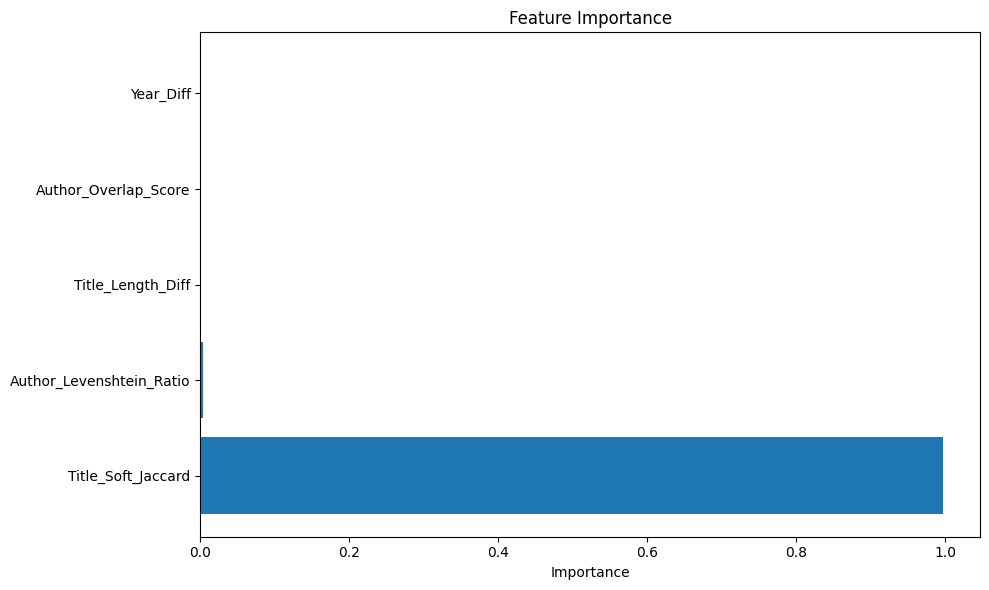

In [351]:
# Feature Importance
print("\nFeature Importance:")
importance_df = get_feature_importance(model, available_features)
display(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## **Prediction**

Predict rankings.

In [352]:
# Predict on test set (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on test set...")
test_predictions = predict_rankings(model, df_test, available_features, top_k=5)

# Predict on validation set
print("Predicting on validation set...")
val_predictions = predict_rankings(model, df_val, available_features, top_k=5)

# Predict on train set
print("Predicting on train set...")
train_predictions = predict_rankings(model, df_train, available_features, top_k=5)

test_groundtruth = extract_groundtruth(df_test)
val_groundtruth = extract_groundtruth(df_val)
train_groundtruth = extract_groundtruth(df_train)

print(f"\nGroundtruth extracted:")
print(f"  Test: {sum(len(v) for v in test_groundtruth.values())} references across {len(test_groundtruth)} publications")
print(f"  Valid: {sum(len(v) for v in val_groundtruth.values())} references across {len(val_groundtruth)} publications")
print(f"  Train: {sum(len(v) for v in train_groundtruth.values())} references across {len(train_groundtruth)} publications")

Predicting on test set...
Predicting on validation set...
Predicting on train set...

Groundtruth extracted:
  Test: 2 references across 1 publications
  Valid: 7 references across 1 publications
  Train: 230 references across 12 publications


## **Evaluation**

Evaluate using MRR metric.

In [353]:
# Flatten for evaluation
test_predictions_flat = flatten_nested_dict(test_predictions)
test_groundtruth_flat = flatten_groundtruth(test_groundtruth)

val_predictions_flat = flatten_nested_dict(val_predictions)
val_groundtruth_flat = flatten_groundtruth(val_groundtruth)

train_predictions_flat = flatten_nested_dict(train_predictions)
train_groundtruth_flat = flatten_groundtruth(train_groundtruth)

# Evaluate on test set
print("="*70)
print("Evaluating on TEST set")
print("="*70)
test_mrr = calculate_mrr(test_predictions_flat, test_groundtruth_flat)
print(f"  Test MRR: {test_mrr:.4f}")

Evaluating on TEST set
  Test MRR: 1.0000


In [354]:
"""
Comprehensive Evaluation: Train/Valid/Test MRR
================================================
Check for overfitting by comparing MRR across all partitions
"""

print("="*70)
print("Model Evaluation")
print("="*70)

# Calculate MRR for all partitions
train_mrr = calculate_mrr(train_predictions_flat, train_groundtruth_flat)
val_mrr = calculate_mrr(val_predictions_flat, val_groundtruth_flat)
# test_mrr already calculated above

print("\n1. MRR Scores Across Partitions:")
print(f"  Train MRR: {train_mrr:.4f}")
print(f"  Valid MRR: {val_mrr:.4f}")
print(f"  Test MRR:  {test_mrr:.4f}")

# Check overfitting
train_test_gap = abs(train_mrr - test_mrr)
print(f"\n2. Overfitting Check:")
print(f"  Train-Test Gap: {train_test_gap:.4f}")
if train_test_gap < 0.05:
    print("  No significant overfitting detected!")
elif train_test_gap < 0.10:
    print("  Slight overfitting (acceptable)")
else:
    print("  Significant overfitting detected!")

Model Evaluation

1. MRR Scores Across Partitions:
  Train MRR: 1.0000
  Valid MRR: 1.0000
  Test MRR:  1.0000

2. Overfitting Check:
  Train-Test Gap: 0.0000
  No significant overfitting detected!


## **Evaluation**
Export pred.json files for all publications in the dataset.

In [355]:
def get_partition(pub_id, test_pub_ids, val_pub_ids, train_pub_ids):
    """Determine which partition a publication belongs to"""
    if pub_id in test_pub_ids:
        return "test"
    elif pub_id in val_pub_ids:
        return "valid"
    elif pub_id in train_pub_ids:
        return "train"
    else:
        return "unknown"

In [356]:
# Load all data (Train, Valid and Test set) to predict
df_all = pd.read_csv("../src/featured_dataset.csv")

# Get pub_ids for each partition
train_pub_ids = set(df_train['pub_id'].unique())
val_pub_ids = set(df_val['pub_id'].unique())
test_pub_ids = set(df_test['pub_id'].unique())

# Predict rankings for ALL data (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on all data (Train, Valid and Test set)...")
all_predictions = predict_rankings(model, df_all, available_features, top_k=5)

# Extract groundtruth (nested dict: {pub_id: {bib_key: arxiv_id}})
all_groundtruth = extract_groundtruth(df_all)

# Export pred.json for each publication
exported = {"train": 0, "valid": 0, "test": 0, "unknown": 0}
for pub_id, predictions in all_predictions.items():
    pub_folder = Path(OUTPUT_DIR + "/" + pub_id)
    pub_folder.mkdir(parents=True, exist_ok=True)
    
    # Determine correct partition for this publication
    partition = get_partition(pub_id, test_pub_ids, val_pub_ids, train_pub_ids)
    
    # Build pred.json
    pred_json = {
        "partition": partition,
        "groundtruth": all_groundtruth.get(pub_id, {}),
        "prediction": predictions
    }
    
    # Export to file
    output_file = pub_folder / "pred.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(pred_json, f, indent=2, ensure_ascii=False)
    
    exported[partition] += 1

print(f"\n{'='*60}")
print(f"Export Complete")
print(f"{'='*60}")
print(f"  pred.json files exported:")
print(f"    - Train: {exported['train']}")
print(f"    - Valid: {exported['valid']}")
print(f"    - Test:  {exported['test']}")
print(f"  Output folder: {OUTPUT_DIR}/")
print(f"{'='*60}")

Predicting on all data (Train, Valid and Test set)...

Export Complete
  pred.json files exported:
    - Train: 15
    - Valid: 2
    - Test:  2
  Output folder: 23127453/
